In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import plotly.graph_objects as go
import pandas as pd
import heapq

np.random.seed(42)

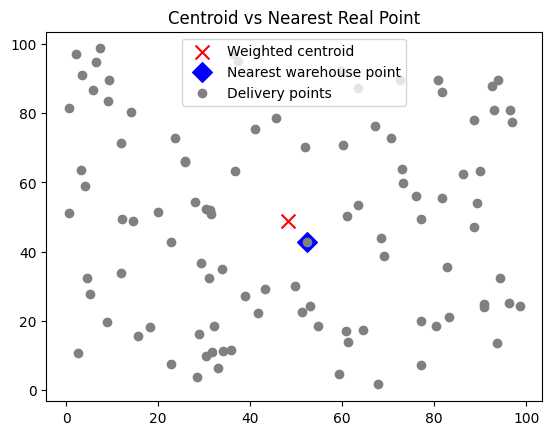

In [ ]:
n = 100

# Simulación de puntos de entrega con coordenadas aleatorias
locations = np.random.rand(n, 2) * 100    # Coordenadas X, Y
weights = np.random.randint(50, 200, n)   # Peso de cada entrega (kg)

# Calcular el punto más eficiente para ser el almacén (centro de masa ponderado por peso)
centroid = np.average(locations, axis=0, weights=weights)
warehouse_index, _ = pairwise_distances_argmin_min([centroid], locations)
warehouse = locations[warehouse_index[0]]

plt.scatter(*centroid, c='red', marker='x', s=100, label='Weighted centroid')
plt.scatter(*warehouse, c='blue', marker='D', s=100, label='Nearest warehouse point')
plt.scatter(locations[:, 0], locations[:, 1], c='gray', label='Delivery points')
plt.legend()
plt.title("Centroid vs Nearest Real Point")
plt.grid(False)
plt.show()

# Eliminar el almacén de locations y su peso
locations = np.delete(locations, warehouse_index[0], axis=0)
weights = np.delete(weights, warehouse_index[0])

# Añadimos almacén a la lista de puntos
all_points = np.vstack([warehouse, locations])
all_weights = np.hstack([0, weights])  # almacén sin peso

all_points_dict = {i: tuple(coord) for i, coord in enumerate(all_points)}

In [3]:
# Parámetros
MAX_WEIGHT = 1000

# Cantidad mínima de rutas
required_routes = int(np.ceil(np.sum(weights) / MAX_WEIGHT))

# Clustering para dividir en rutas
kmeans = KMeans(n_clusters=required_routes, random_state=42)
route_labels = kmeans.fit_predict(locations)
route_labels

array([11,  8,  9,  2,  0,  2,  3,  9, 12,  1, 10, 12,  7,  4, 10, 10,  2,
        6,  5,  8,  4,  2,  7, 12,  1,  6,  6,  0,  9,  9,  1,  3, 12,  2,
        2,  3,  2,  0, 10,  5,  8,  5, 12,  8,  8,  2,  8,  8,  9,  4, 12,
        3,  7,  5,  5,  6,  0,  3,  8,  6,  5, 12,  6,  4,  1,  9,  3,  7,
       11,  3,  1,  5,  8,  9,  3,  4,  3,  0,  7,  7,  8,  2,  5,  4, 10,
        1, 10,  8,  3,  5,  6,  7,  8,  1,  2,  8, 12,  0,  6],
      dtype=int32)

In [4]:
# Grafo completo
G = nx.Graph()
for i in range(len(all_points)):
    G.add_node(i, pos=tuple(all_points[i]))
for i in range(len(all_points)):
    for j in range(i+1, len(all_points)):
        dist = np.linalg.norm(all_points[i] - all_points[j])
        G.add_edge(i, j, weight=dist)

In [5]:
def nearest_neighbor_route(graph, start_node, nodes_to_visit):
    unvisited = set(nodes_to_visit)
    current = start_node
    route = [current]
    unvisited.discard(current)
    while unvisited:
        nearest = min(unvisited, key=lambda x: graph[current][x]['weight'])
        route.append(nearest)
        unvisited.remove(nearest)
        current = nearest
    route.append(start_node)
    return route

In [6]:
route_summaries = []

for r in range(required_routes):
    cluster_points_indices = [0] + [i+1 for i, label in enumerate(route_labels) if label == r]
    route = nearest_neighbor_route(G, start_node=0, nodes_to_visit=set(cluster_points_indices))
    
    # Lista de puntos con sus pesos
    points_list = [{'point': i, 'weight': round(all_weights[i])} for i in route]
    # points_list = [(i, round(all_weights[i])) for i in route]
    
    # Peso total (excepto almacén)
    total_weight = sum(all_weights[i] for i in route if i != 0)
    
    # Cantidad de puntos (sin incluir el almacén)
    num_points = len([i for i in route if i != 0])
    
    route_summaries.append({
        'route_id': r + 1,
        'total_weight': round(total_weight),
        'num_points': num_points,
        'points': points_list
    })

route_summaries

[{'route_id': 1,
  'total_weight': 706,
  'num_points': 6,
  'points': [{'point': 0, 'weight': 0},
   {'point': 5, 'weight': 133},
   {'point': 78, 'weight': 148},
   {'point': 38, 'weight': 77},
   {'point': 57, 'weight': 165},
   {'point': 28, 'weight': 71},
   {'point': 98, 'weight': 112},
   {'point': 0, 'weight': 0}]},
 {'route_id': 2,
  'total_weight': 920,
  'num_points': 7,
  'points': [{'point': 0, 'weight': 0},
   {'point': 71, 'weight': 179},
   {'point': 10, 'weight': 177},
   {'point': 31, 'weight': 100},
   {'point': 65, 'weight': 153},
   {'point': 86, 'weight': 114},
   {'point': 94, 'weight': 115},
   {'point': 25, 'weight': 82},
   {'point': 0, 'weight': 0}]},
 {'route_id': 3,
  'total_weight': 1191,
  'num_points': 10,
  'points': [{'point': 0, 'weight': 0},
   {'point': 46, 'weight': 66},
   {'point': 34, 'weight': 76},
   {'point': 82, 'weight': 184},
   {'point': 4, 'weight': 153},
   {'point': 95, 'weight': 81},
   {'point': 17, 'weight': 70},
   {'point': 35, 'w

In [7]:
df_routes = pd.DataFrame(route_summaries)
df_routes

,route_id,total_weight,num_points,points
0,1,706,6,"[{'point': 0, 'weight': 0}, {'point': 5, 'weig..."
1,2,920,7,"[{'point': 0, 'weight': 0}, {'point': 71, 'wei..."
2,3,1191,10,"[{'point': 0, 'weight': 0}, {'point': 46, 'wei..."
3,4,1170,10,"[{'point': 0, 'weight': 0}, {'point': 32, 'wei..."
4,5,764,6,"[{'point': 0, 'weight': 0}, {'point': 14, 'wei..."
5,6,1152,9,"[{'point': 0, 'weight': 0}, {'point': 83, 'wei..."
6,7,1117,8,"[{'point': 0, 'weight': 0}, {'point': 99, 'wei..."
7,8,822,7,"[{'point': 0, 'weight': 0}, {'point': 80, 'wei..."
8,9,1755,13,"[{'point': 0, 'weight': 0}, {'point': 73, 'wei..."
9,10,956,7,"[{'point': 0, 'weight': 0}, {'point': 66, 'wei..."


In [15]:
def plot_routes(routes:list[dict], warehouse:np.array):
    colors = ['#8c564b', '#7f7f7f', '#bcbd22', '#17becf', '#e377c2', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']

    fig = go.Figure()

    for r, route_info in enumerate(routes):
        route = [p['point'] for p in route_info['points']]
        rout_id = route_info['route_id']
        route_coords = np.array([all_points[i] for i in route])
        total_weight = route_info['total_weight']
        
        # Construimos el texto para hover con peso total y peso punto a punto
        hover_texts = []
        for i in route:
            if i == 0:
                hover_texts.append(f"Route {rout_id}<br>Warehouse<br>Total weight: {total_weight} kg")
            else:
                hover_texts.append(f"Route {rout_id}<br>Point {i}<br>Weight: {all_weights[i]} kg<br>Total weight: {total_weight} kg")
        
        overloaded = total_weight > MAX_WEIGHT
        line_width = 3 if overloaded else 1
        marker_size = 8 if overloaded else 4
        line_dash = 'solid' if overloaded else 'dash'

        fig.add_trace(go.Scatter(
            x=route_coords[:, 0],
            y=route_coords[:, 1],
            mode='lines+markers',
            line=dict(
                color=colors[rout_id % len(colors)],
                width=line_width,
                dash=line_dash
            ),
            marker=dict(size=marker_size, symbol='diamond'),
            name=f'Route {rout_id}',
            hoverinfo='text',
            text=hover_texts,
            hoverlabel=dict(bgcolor=colors[rout_id % len(colors)])
        ))

    # Marcador del almacén más grande y negro
    fig.add_trace(go.Scatter(
        x=[warehouse[0]],
        y=[warehouse[1]],
        mode='markers',
        marker=dict(size=20, color='black', symbol='star'),
        name='Warehouse',
        hoverinfo='text',
        text=['Warehouse']
    ))

    fig.update_layout(
        template='simple_white',
        title="Rutas optimizadas con límite de peso - Interactivo",
        showlegend=False,
        hovermode='closest',
        xaxis=dict(title='X coordinate'),
        yaxis=dict(title='Y coordinate'),
        width=600,
        height=600
    )

    fig.show()

In [9]:
plot_routes(route_summaries, warehouse)

In [16]:
# Paso 1: Agrupar rutas con exceso y rutas con espacio
overloaded_routes = [r for r in route_summaries if r['total_weight'] > MAX_WEIGHT]
underloaded_routes = [r for r in route_summaries if r['total_weight'] < MAX_WEIGHT]

print(len(overloaded_routes), "overloaded routes")
print(len(underloaded_routes), "underloaded routes")

# Remover almacenes temporales
for route in overloaded_routes + underloaded_routes:
    if route['points'] and route['points'][-1]['point'] == 0:
        route['points'].pop()

# Paso 2: Crear heap de todos los pares punto–ruta disponibles
heap = []

for over_route in overloaded_routes:
    for point in over_route['points']:
        if point['point'] == 0:
            continue  # ignorar almacén

        point_coord = np.array([all_points[point['point']]])

        for under_route in underloaded_routes:
            if point['weight'] + under_route['total_weight'] > MAX_WEIGHT:
                continue  # No tiene espacio

            # Obtener coordenadas de puntos actuales de la ruta
            route_coords = np.array([
                all_points[p['point']] for p in under_route['points'] if p['point'] != 0
            ])

            if route_coords.size == 0:
                route_coords = np.array([all_points[0]])  # almacén

            # Buscar punto más cercano de la ruta
            _, distances = pairwise_distances_argmin_min(point_coord, route_coords)

            heapq.heappush(heap, (distances[0], point, over_route, under_route))

# Paso 3: Mover puntos por prioridad (distancia mínima)
moved_points = set()

while heap:
    distance, point, over_route, under_route = heapq.heappop(heap)
    point_id = (over_route['route_id'], point['point'])

    if point_id in moved_points:
        continue  # ya fue movido por otro par

    if point not in over_route['points']:
        continue  # ya fue movido en otra iteración

    if point['weight'] + under_route['total_weight'] > MAX_WEIGHT:
        continue  # ya no hay espacio

    # Movemos el punto
    over_route['points'].remove(point)
    over_route['total_weight'] -= point['weight']
    over_route['num_points'] -= 1

    under_route['points'].append(point)
    under_route['total_weight'] += point['weight']
    under_route['num_points'] += 1

    # Punto movido de X a Y
    print(f"Moved point {point['point']} (weight {point['weight']} kg) from route {over_route['route_id']} to route {under_route['route_id']}")
        
# Restaurar almacenes al final
for route in overloaded_routes + underloaded_routes:
    if not route['points'] or route['points'][-1]['point'] != 0:
        route['points'].append({'point': 0, 'weight': 0})

2 overloaded routes
11 underloaded routes
Moved point 45 (weight 98 kg) from route 9 to route 4
Moved point 81 (weight 109 kg) from route 9 to route 3
Moved point 73 (weight 153 kg) from route 9 to route 3
Moved point 2 (weight 124 kg) from route 9 to route 3
Moved point 83 (weight 106 kg) from route 6 to route 3
Moved point 47 (weight 95 kg) from route 9 to route 3
Moved point 20 (weight 177 kg) from route 9 to route 3


In [17]:
df_final_routes = pd.DataFrame(route_summaries)
df_final_routes

,route_id,total_weight,num_points,points
0,1,964,9,"[{'point': 0, 'weight': 0}, {'point': 5, 'weig..."
1,2,994,8,"[{'point': 0, 'weight': 0}, {'point': 71, 'wei..."
2,3,925,7,"[{'point': 0, 'weight': 0}, {'point': 6, 'weig..."
3,4,1000,8,"[{'point': 0, 'weight': 0}, {'point': 32, 'wei..."
4,5,976,8,"[{'point': 0, 'weight': 0}, {'point': 14, 'wei..."
5,6,906,6,"[{'point': 0, 'weight': 0}, {'point': 55, 'wei..."
6,7,943,6,"[{'point': 0, 'weight': 0}, {'point': 99, 'wei..."
7,8,979,9,"[{'point': 0, 'weight': 0}, {'point': 80, 'wei..."
8,9,915,6,"[{'point': 0, 'weight': 0}, {'point': 88, 'wei..."
9,10,956,7,"[{'point': 0, 'weight': 0}, {'point': 66, 'wei..."


In [18]:
plot_routes(route_summaries, warehouse)

In [13]:
plot_routes(underloaded_routes, warehouse)

In [14]:
plot_routes(overloaded_routes, warehouse)